In [31]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.callbacks import EarlyStopping, LambdaCallback
from keras.utils import to_categorical
from keras.models import Model
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import scipy

1999 0.61 0.46


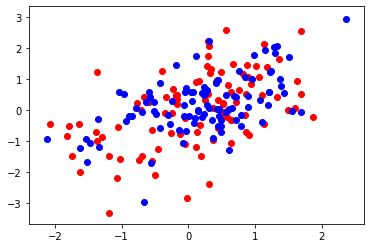

3999 0.62 0.43


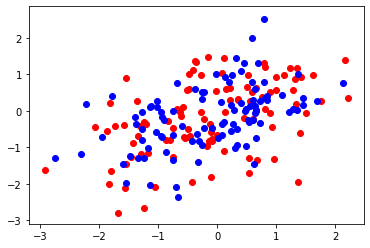

5999 0.51 0.31


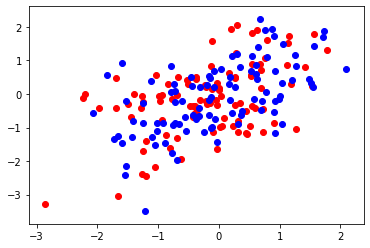

7999 0.01 0.97


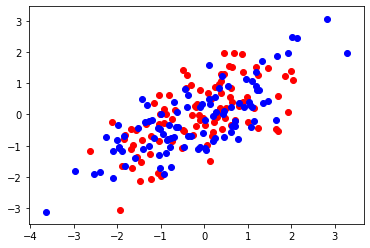

9999 0.36 0.86


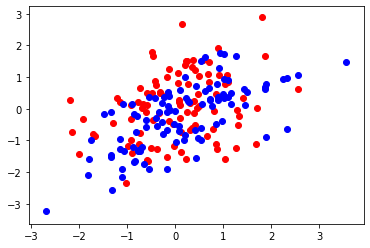

In [32]:
#Quick vanilla GAN from https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/
 
# define the standalone discriminator model
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))    
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))    
	model.add(Dense(n_outputs, activation='linear'))
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model
 
# generate n real samples with class labels
def generate_real_samples(n):
	Z1 = np.random.normal(0,1,n)
	Z2 = np.random.normal(0,1,n)
	rho = 0.5
    
	X1 = Z1
	X2 = rho*Z1 + np.sqrt(1.-rho**2)*Z2
    
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)    
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y
 
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
	pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	pyplot.show()
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)
 
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

In [33]:
xvals,yvals = generate_fake_samples(generator, latent_dim, 100000)

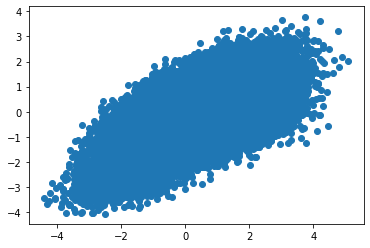

In [34]:
plt.scatter(xvals[:, 0],xvals[:, 1])

In [35]:
print(np.mean(xvals[:, 0]))
print(np.std(xvals[:, 0]))

print(np.mean(xvals[:, 1]))
print(np.std(xvals[:, 1]))

print(scipy.stats.pearsonr(xvals[:, 0],xvals[:, 1])[0])

0.07894659
1.1203839
-0.19999984
1.0051223
0.6486153449079094


In [6]:
#Now, let's try to DCTR this up!

In [36]:
xvalsR,yvalsR = generate_real_samples(100000)

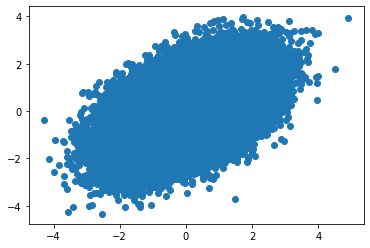

In [37]:
plt.scatter(xvalsR[:, 0],xvalsR[:, 1])

In [38]:
print(np.mean(xvalsR[:, 0]))
print(np.std(xvalsR[:, 0]))

print(np.mean(xvalsR[:, 1]))
print(np.std(xvalsR[:, 1]))

print(scipy.stats.pearsonr(xvalsR[:, 0],xvalsR[:, 1])[0])

0.000998230486103162
0.9980008200852595
0.002413602967930827
0.9999069885147919
0.49801185962585603


In [39]:
X = np.concatenate([xvalsR,xvals])
Y = np.concatenate([yvalsR,yvals])
Y = to_categorical(Y)

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [41]:
inputs = Input((2,))
hidden_layer_1 = Dense(20, activation='relu')(inputs)
hidden_layer_2 = Dense(20, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(20, activation='relu')(hidden_layer_2)

outputs = Dense(2, activation='softmax')(hidden_layer_3)

model = Model(inputs = inputs, outputs = outputs)
model.compile(loss='categorical_crossentropy', optimizer='Adam', )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 20)                60        
_________________________________________________________________
dense_12 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_13 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 42        
Total params: 942
Trainable params: 942
Non-trainable params: 0
_________________________________________________________________


In [42]:
earlystopping = EarlyStopping(patience = 10)
model.fit(X_train, Y_train, 
          epochs=100, 
          batch_size = 1000,
          validation_data = (X_test, Y_test),
          callbacks = [earlystopping])

Train on 160000 samples, validate on 40000 samples
Epoch 1/100
160000/160000 [==============================] - 1s 8us/step - loss: 0.6740 - val_loss: 0.6697
Epoch 2/100
160000/160000 [==============================] - 1s 6us/step - loss: 0.6693 - val_loss: 0.6685
Epoch 3/100
160000/160000 [==============================] - 1s 6us/step - loss: 0.6680 - val_loss: 0.6669
Epoch 4/100
160000/160000 [==============================] - 1s 6us/step - loss: 0.6670 - val_loss: 0.6660
Epoch 5/100
160000/160000 [==============================] - 1s 6us/step - loss: 0.6666 - val_loss: 0.6656
Epoch 6/100
160000/160000 [==============================] - 1s 6us/step - loss: 0.6659 - val_loss: 0.6654
Epoch 7/100
160000/160000 [==============================] - 1s 6us/step - loss: 0.6657 - val_loss: 0.6659
Epoch 8/100
160000/160000 [==============================] - 1s 6us/step - loss: 0.6653 - val_loss: 0.6649
Epoch 9/100
160000/160000 [==============================] - 1s 6us/step - loss: 0.6650 - val

In [43]:
preds = model.predict(X_test)
weights = preds[:,1]/preds[:,0]

(array([  91., 1238.,  976., 1615., 2227., 3555., 4404., 2584., 1141.,
         680.,  412.,  286.,  153.,   83.,   56.,   54.,   68.,   35.,
          34.]),
 array([0.        , 0.15789474, 0.31578947, 0.47368421, 0.63157895,
        0.78947368, 0.94736842, 1.10526316, 1.26315789, 1.42105263,
        1.57894737, 1.73684211, 1.89473684, 2.05263158, 2.21052632,
        2.36842105, 2.52631579, 2.68421053, 2.84210526, 3.        ]),
 <a list of 19 Patch objects>)

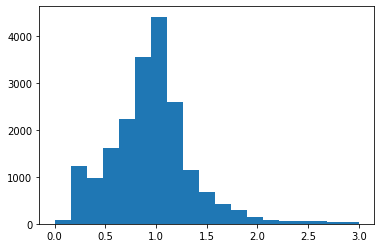

In [44]:
plt.hist(weights[Y_test[:,0]==1],bins=np.linspace(0,3,20))

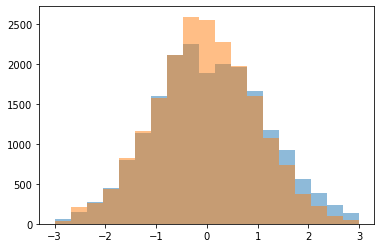

In [45]:
_,_,_=plt.hist(X_test[Y_test[:,0]==1][:, 0],alpha=0.5,bins=np.linspace(-3,3,20))
_,_,_=plt.hist(X_test[Y_test[:,0]==1][:, 0],weights=weights[Y_test[:,0]==1],alpha=0.5,bins=np.linspace(-3,3,20))

In [53]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

def std(x, w):
    """Weighted Covariance"""
    return cov(x,x,w)**0.5

In [56]:
print("X1 mean")
print("DCTRGAN:",np.average(X_test[Y_test[:,0]==1][:,0],weights=weights[Y_test[:,0]==1]))
print("GAN:",np.average(X_test[Y_test[:,0]==1][:,0]))

print("X2 mean")
print("DCTRGAN:",np.average(X_test[Y_test[:,0]==1][:,1],weights=weights[Y_test[:,0]==1]))
print("GAN:",np.average(X_test[Y_test[:,0]==1][:,1]))

print("\n")

print("X1 standard deviation")
print("DCTRGAN:",std(X_test[Y_test[:,0]==1][:,0],weights[Y_test[:,0]==1]))
print("GAN:",std(X_test[Y_test[:,0]==1][:,0],np.ones(len(X_test[Y_test[:,0]==1]))))

print("X2 standard deviation")
print("DCTRGAN:",std(X_test[Y_test[:,0]==1][:,1],weights[Y_test[:,0]==1]))
print("GAN:",std(X_test[Y_test[:,0]==1][:,1],np.ones(len(X_test[Y_test[:,0]==1]))))

print("\n")

print("X1,X2 correlation")
print("DCTRGAN:",corr(X_test[Y_test[:,0]==1][:,0],X_test[Y_test[:,0]==1][:,1],weights[Y_test[:,0]==1]))
print("GAN:",corr(X_test[Y_test[:,0]==1][:,0],X_test[Y_test[:,0]==1][:,1],np.ones(len(X_test[Y_test[:,0]==1]))))

X1 mean
DCTRGAN: -0.038893118623462286
GAN: 0.06714635978844259
X2 mean
DCTRGAN: -0.016131852984098367
GAN: -0.21643264626812306


X1 standard deviation
DCTRGAN: 1.0123614673085537
GAN: 1.1274273990978627
X2 standard deviation
DCTRGAN: 1.0117445336448037
GAN: 1.0154279286594114


X1,X2 correlation
DCTRGAN: 0.496575742119486
GAN: 0.657081736842469


1999 0.6225 0.3584


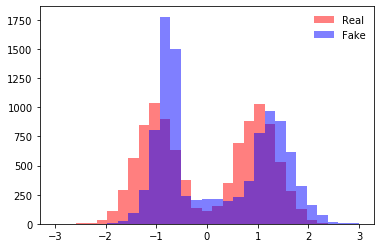

3999 0.9644 0.0331


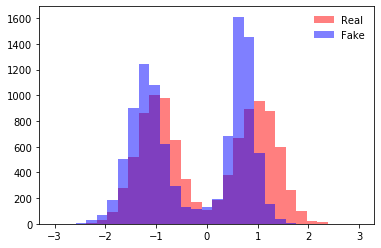

5999 0.1943 0.7802


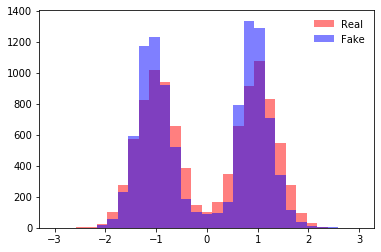

7999 0.3632 0.6856


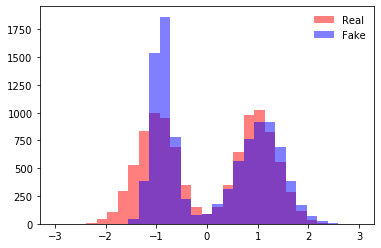

9999 0.0171 0.9898


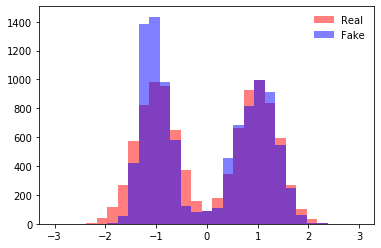

In [110]:
# generate n real samples with class labels
def generate_real_samples_twomodes(n):
	Z1 = np.random.normal(-1,0.4,int(n/2))
	Z2 = np.random.normal(1,0.4,n-int(n/2))
	X = np.concatenate([Z1,Z2])
	np.random.shuffle(X)
	# generate class labels
	y = ones((n, 1))
	return X, y

 
# evaluate the discriminator and plot real and fake points
def summarize_performance_1D(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples_twomodes(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	pyplot.hist(x_real, color='red',alpha=0.5,bins=np.linspace(-3,3,30),label="Real")
	pyplot.hist(x_fake, color='blue',alpha=0.5,bins=np.linspace(-3,3,30),label="Fake")
	pyplot.legend(frameon=False)
	pyplot.show()
 
# train the generator and discriminator
def train_twomodes(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples_twomodes(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance_1D(i, g_model, d_model, latent_dim,10000)
 
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator_twomodes = define_discriminator(1)
# create the generator
generator_twomodes = define_generator(latent_dim,1)
# create the gan
gan_model_twomodes = define_gan(generator_twomodes, discriminator_twomodes)
# train model
train_twomodes(generator_twomodes, discriminator_twomodes, gan_model_twomodes, latent_dim)

In [165]:
xvals_1D,yvals_1D = generate_fake_samples(generator_twomodes, latent_dim, 1000000)
xvalsR_1D,yvalsR_1D = generate_real_samples_twomodes(1000000)
X_1D = np.concatenate([xvalsR_1D,xvals_1D[:,0]])
Y_1D = np.concatenate([yvalsR_1D,yvals_1D])
Y_1D = to_categorical(Y_1D)
X_1D_train, X_1D_test, Y_1D_train, Y_1D_test = train_test_split(X_1D, Y_1D, test_size=0.2)

In [166]:
inputs_1D = Input((1,))
hidden_layer_1_1D = Dense(20, activation='relu')(inputs_1D)
hidden_layer_2_1D = Dense(20, activation='relu')(hidden_layer_1_1D)
hidden_layer_3_1D = Dense(20, activation='relu')(hidden_layer_2_1D)

outputs_1D = Dense(2, activation='softmax')(hidden_layer_3_1D)

model_1D = Model(inputs = inputs_1D, outputs = outputs_1D)
model_1D.compile(loss='categorical_crossentropy', optimizer='Adam', )
model_1D.summary()

model_1D.fit(X_1D_train, Y_1D_train, 
          epochs=100, 
          batch_size = 1000,
          validation_data = (X_1D_test, Y_1D_test),
          callbacks = [earlystopping])

preds_1D = model_1D.predict(X_1D_test)
weights_1D = preds_1D[:,1]/preds_1D[:,0]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_147 (Dense)            (None, 20)                40        
_________________________________________________________________
dense_148 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_149 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_150 (Dense)            (None, 2)                 42        
Total params: 922
Trainable params: 922
Non-trainable params: 0
_________________________________________________________________
Train on 1600000 samples, validate on 400000 samples
Epoch 1/100
1600000/1600000 [==============================] - 12s 8us/step - loss: 0.6793 

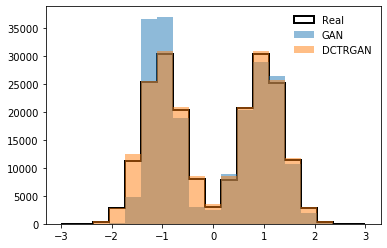

In [167]:
_,_,_=plt.hist(X_1D_test[Y_1D_test[:,0]==0],bins=np.linspace(-3,3,20),label="Real",histtype="step",color="black",lw=2)
_,_,_=plt.hist(X_1D_test[Y_1D_test[:,0]==1],alpha=0.5,bins=np.linspace(-3,3,20),label="GAN")
_,_,_=plt.hist(X_1D_test[Y_1D_test[:,0]==1],weights=weights_1D[Y_1D_test[:,0]==1],alpha=0.5,bins=np.linspace(-3,3,20),label="DCTRGAN")
plt.legend(frameon=False)

In [168]:
import seaborn as sns

In [423]:
def resample(x,w,n):
    myweights = w/sum(w)
    myweights[0] = myweights[0] + (1.-sum(myweights))
    myweights = np.abs(myweights)
    mycounts = np.random.multinomial(n,myweights)
    myout = []
    for i in range(len(x)):
        for j in range(mycounts[i]):
            myout+=[x[i]]
            pass
        pass
    return myout

In [283]:
dctrgan1d = resample(X_1D_test[Y_1D_test[:,0]==1],weights_1D[Y_1D_test[:,0]==1],100000)

Text(0.5, 1.0, 'DCTRGAN')

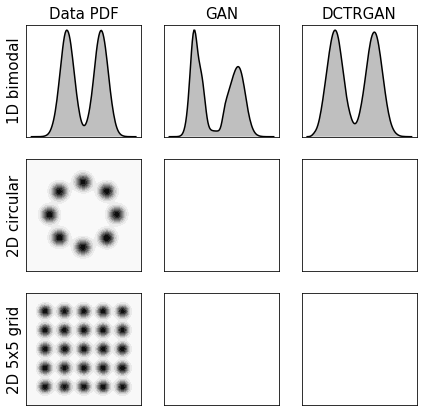

In [284]:
f, axes = plt.subplots(3, 3, figsize=(7, 7))

for i in range(3):
    for j in range(3):
        plt.sca(axes[i, j])
        plt.xticks(fontsize=0)
        plt.yticks(fontsize=0)
        plt.xticks([], [])
        plt.yticks([], [])

plt.sca(axes[0, 0])        
plt.ylabel("1D bimodal",fontsize=15)   

plt.sca(axes[1, 0])        
plt.ylabel("2D circular",fontsize=15)   

plt.sca(axes[2, 0])        
plt.ylabel("2D 5x5 grid",fontsize=15)   
    
sns.distplot(X_1D_test[Y_1D_test[:,0]==0], hist=False, color="gray", kde_kws={"shade": True,"color":"black"}, ax=axes[0, 0])
sns.distplot(X_1D_test[Y_1D_test[:,0]==1], hist=False, color="gray", kde_kws={"shade": True,"color":"black"}, ax=axes[0, 1])
sns.distplot(dctrgan1d, hist=False, color="gray", kde_kws={"shade": True,"color":"black"}, ax=axes[0, 2])

xvals = []
yvals = []
for i in range(8):
    xvals = np.concatenate([xvals,np.random.normal(np.cos(2*i*3.14/8),0.1,1000)])
    yvals = np.concatenate([yvals,np.random.normal(np.sin(2*i*3.14/8),0.1,1000)])
    pass

sns.kdeplot(xvals, yvals, shade=True,cmap="Greys", ax=axes[1, 0])

xvals2 = []
yvals2 = []
for i in range(5):
    for j in range(5):
        xvals2 = np.concatenate([xvals2,np.random.normal(i+0.1,0.1,1000)])
        yvals2 = np.concatenate([yvals2,np.random.normal(j+0.1,0.1,1000)])
        pass
    pass

sns.kdeplot(xvals2, yvals2, shade=True,cmap="Greys", ax=axes[2, 0])    
    
axes[0][0].set_title('Data PDF',fontsize=15)
axes[0][1].set_title('GAN',fontsize=15)
axes[0][2].set_title('DCTRGAN',fontsize=15)

1999 0.8248 0.6726


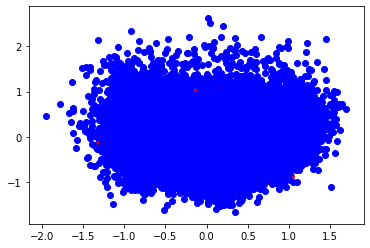

3999 0.4995 0.6705


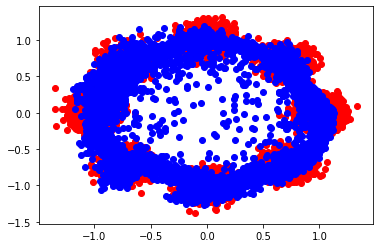

5999 0.477 0.6275


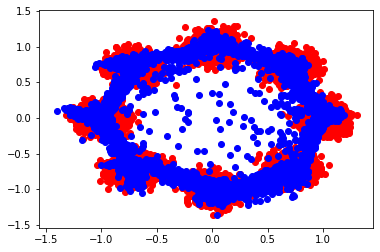

7999 0.3188 0.7441


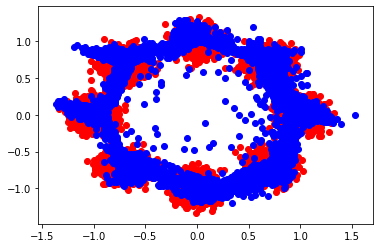

9999 0.4528 0.5656


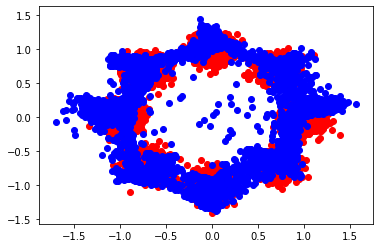

In [405]:
# generate n real samples with class labels
def generate_real_samples_2dcircular(n):
    
	amounts = np.random.multinomial(n,np.ones(8)/8.)
	X1 = []
	X2 = []
	mycounter = 0
	for i in range(8):
		X1 = np.concatenate([X1,np.random.normal(np.cos(2*i*3.14/8),0.1,amounts[mycounter])])
		X2 = np.concatenate([X2,np.random.normal(np.sin(2*i*3.14/8),0.1,amounts[mycounter])])
		mycounter+=1
		pass

	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)    
	X = hstack((X1, X2))
	np.random.shuffle(X)
	# generate class labels
	y = ones((n, 1))
	return X, y

 
# evaluate the discriminator and plot real and fake points
def summarize_performance_2dcircular(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples_2dcircular(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
	pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	pyplot.show()
 
# train the generator and discriminator
def train_2dcircular(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples_2dcircular(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance_2dcircular(i, g_model, d_model, latent_dim,10000)
 
# size of the latent space
latent_dim = 8
# create the discriminator
discriminator_2dcircular = define_discriminator(2)
# create the generator
generator_2dcircular = define_generator(latent_dim,2)
# create the gan
gan_model_2dcircular = define_gan(generator_2dcircular, discriminator_2dcircular)
# train model
train_2dcircular(generator_2dcircular, discriminator_2dcircular, gan_model_2dcircular, latent_dim)

In [406]:
xvals_2Dcirc,yvals_2Dcirc = generate_fake_samples(generator_2dcircular, latent_dim, 1000000)
xvalsR_2Dcirc,yvalsR_2Dcirc = generate_real_samples_2dcircular(1000000)
X_2Dcirc = np.concatenate([xvalsR_2Dcirc,xvals_2Dcirc])
Y_2Dcirc = np.concatenate([yvalsR_2Dcirc[:,0],yvals_2Dcirc[:,0]])
Y_2Dcirc = to_categorical(Y_2Dcirc)
X_2Dcirc_train, X_2Dcirc_test, Y_2Dcirc_train, Y_2Dcirc_test = train_test_split(X_2Dcirc, Y_2Dcirc, test_size=0.2)

on 2d circular plots
on GAN part
on 2d grid plots


Text(0.5, 1.0, 'DCTRGAN')

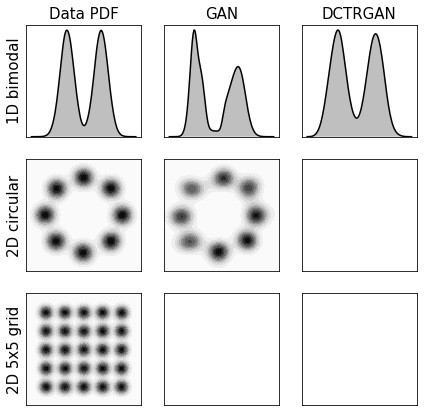

In [261]:
f, axes = plt.subplots(3, 3, figsize=(7, 7))

for i in range(3):
    for j in range(3):
        plt.sca(axes[i, j])
        plt.xticks(fontsize=0)
        plt.yticks(fontsize=0)
        plt.xticks([], [])
        plt.yticks([], [])

plt.sca(axes[0, 0])        
plt.ylabel("1D bimodal",fontsize=15)   

plt.sca(axes[1, 0])        
plt.ylabel("2D circular",fontsize=15)   

plt.sca(axes[2, 0])        
plt.ylabel("2D 5x5 grid",fontsize=15)   
    
sns.distplot(X_1D_test[Y_1D_test[:,0]==0], hist=False, color="gray", kde_kws={"shade": True,"color":"black"}, ax=axes[0, 0])
sns.distplot(X_1D_test[Y_1D_test[:,0]==1], hist=False, color="gray", kde_kws={"shade": True,"color":"black"}, ax=axes[0, 1])
sns.distplot(dctrgan1d, hist=False, color="gray", kde_kws={"shade": True,"color":"black"}, ax=axes[0, 2])

xvals = []
yvals = []
for i in range(8):
    xvals = np.concatenate([xvals,np.random.normal(np.cos(2*i*3.14/8),0.1,500)])
    yvals = np.concatenate([yvals,np.random.normal(np.sin(2*i*3.14/8),0.1,500)])
    pass

print("on 2d circular plots")
sns.kdeplot(xvals, yvals, shade=True,cmap="Greys", ax=axes[1, 0])
plt.sca(axes[1, 0])
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
print("on GAN part")
sns.kdeplot(xvals_2Dcirc[:,0][0:2000],xvals_2Dcirc[:,1][0:2000], shade=True,cmap="Greys", ax=axes[1, 1])
plt.sca(axes[1, 1])
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])

xvals2 = []
yvals2 = []
for i in range(5):
    for j in range(5):
        xvals2 = np.concatenate([xvals2,np.random.normal(i+0.1,0.1,500)])
        yvals2 = np.concatenate([yvals2,np.random.normal(j+0.1,0.1,500)])
        pass
    pass

print("on 2d grid plots")
sns.kdeplot(xvals2, yvals2, shade=True,cmap="Greys", ax=axes[2, 0])    
    
axes[0][0].set_title('Data PDF',fontsize=15)
axes[0][1].set_title('GAN',fontsize=15)
axes[0][2].set_title('DCTRGAN',fontsize=15)

1999 0.4939 0.6599


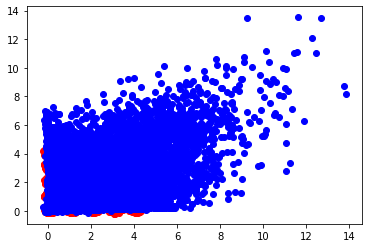

3999 0.2968 0.709


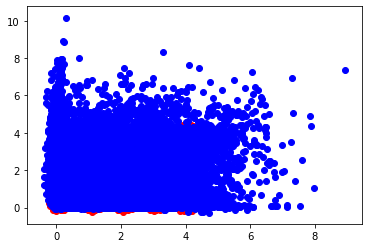

5999 0.6331 0.4533


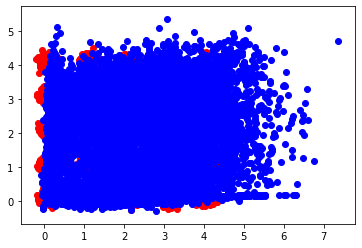

7999 0.3216 0.8032


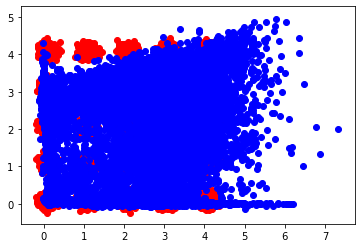

9999 0.2271 0.8219


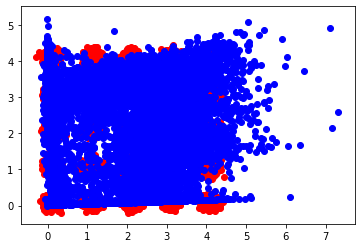

11999 0.6538 0.4658


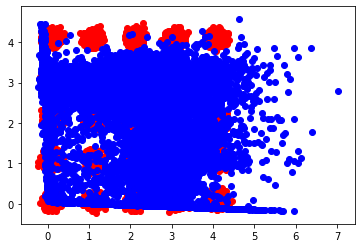

13999 0.222 0.8406


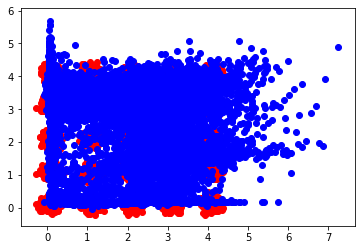

15999 0.4469 0.6826


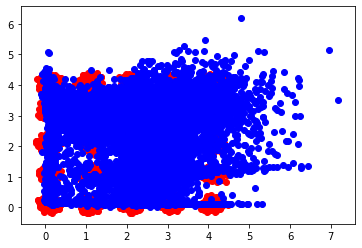

17999 0.3275 0.7585


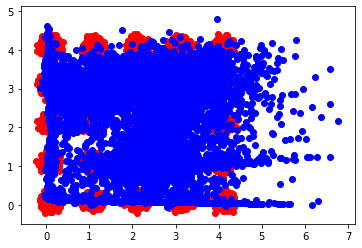

19999 0.4685 0.689


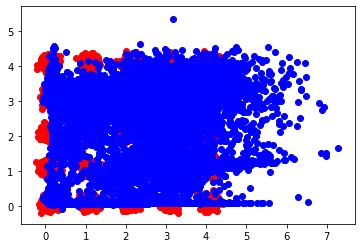

In [279]:
# generate n real samples with class labels
def generate_real_samples_2dsquare(n):
    
	amounts = np.random.multinomial(n,np.ones(25)/25.)
    
	X1 = []
	X2 = []
	mycounter = 0
	for i in range(5):
		for j in range(5):
			X1 = np.concatenate([X1,np.random.normal(i+0.1,0.1,amounts[mycounter])])
			X2 = np.concatenate([X2,np.random.normal(j+0.1,0.1,amounts[mycounter])])
			mycounter+=1
			pass
		pass    
    
	X1 = X1.reshape(len(X1), 1)
	X2 = X2.reshape(len(X2), 1)    
	X = hstack((X1, X2))
	np.random.shuffle(X)
	# generate class labels
	y = ones((n, 1))
	return X, y

 
# evaluate the discriminator and plot real and fake points
def summarize_performance_2dsquare(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples_2dsquare(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
	pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	pyplot.show()
 
# train the generator and discriminator
def train_2dsquare(g_model, d_model, gan_model, latent_dim, n_epochs=20000, n_batch=128, n_eval=2000):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples_2dsquare(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance_2dsquare(i, g_model, d_model, latent_dim,10000)
 
# size of the latent space
latent_dim = 25
# create the discriminator
discriminator_2dsquare = define_discriminator(2)
# create the generator
generator_2dsquare = define_generator(latent_dim,2)
# create the gan
gan_model_2dsquare = define_gan(generator_2dsquare, discriminator_2dsquare)
# train model
train_2dsquare(generator_2dsquare, discriminator_2dsquare, gan_model_2dsquare, latent_dim)

In [352]:
xvals_2Dsquare,yvals_2Dsquare = generate_fake_samples(generator_2dsquare, latent_dim, 1000000)
xvalsR_2Dsquare,yvalsR_2Dsquare = generate_real_samples_2dsquare(1000000)
X_2Dsquare = np.concatenate([xvalsR_2Dsquare,xvals_2Dsquare])
Y_2Dsquare = np.concatenate([yvalsR_2Dsquare,yvals_2Dsquare])
Y_2Dsquare = to_categorical(Y_2Dsquare)
X_2Dsquare_train, X_2Dsquare_test, Y_2Dsquare_train, Y_2Dsquare_test = train_test_split(X_2Dsquare, Y_2Dsquare, test_size=0.2)

on 2d circular plots
on GAN part
on 2d grid plots


Text(0.5, 1.0, 'DCTRGAN')

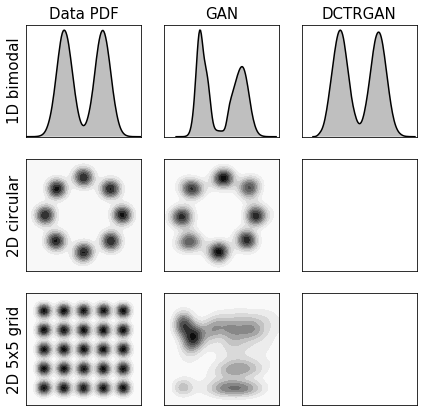

In [316]:
f, axes = plt.subplots(3, 3, figsize=(7, 7))

for i in range(3):
    for j in range(3):
        plt.sca(axes[i, j])
        plt.xticks(fontsize=0)
        plt.yticks(fontsize=0)
        plt.xticks([], [])
        plt.yticks([], [])

plt.sca(axes[0, 0])        
plt.ylabel("1D bimodal",fontsize=15)   

plt.sca(axes[1, 0])        
plt.ylabel("2D circular",fontsize=15)   

plt.sca(axes[2, 0])        
plt.ylabel("2D 5x5 grid",fontsize=15)   
    
sns.distplot(X_1D_test[Y_1D_test[:,0]==0], hist=False, color="gray", kde_kws={"shade": True,"color":"black"}, ax=axes[0, 0])
sns.distplot(X_1D_test[Y_1D_test[:,0]==1], hist=False, color="gray", kde_kws={"shade": True,"color":"black"}, ax=axes[0, 1])
sns.distplot(dctrgan1d, hist=False, color="gray", kde_kws={"shade": True,"color":"black"}, ax=axes[0, 2])

plt.sca(axes[0, 0])
plt.xlim([-3,3])

plt.sca(axes[0, 1])
plt.xlim([-3,3])

plt.sca(axes[0, 2])
plt.xlim([-3,3])

xvals = []
yvals = []
for i in range(8):
    xvals = np.concatenate([xvals,np.random.normal(np.cos(2*i*3.14/8),0.1,500)])
    yvals = np.concatenate([yvals,np.random.normal(np.sin(2*i*3.14/8),0.1,500)])
    pass

print("on 2d circular plots")
sns.kdeplot(xvals, yvals, shade=True,cmap="Greys", ax=axes[1, 0])
plt.sca(axes[1, 0])
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
print("on GAN part")
sns.kdeplot(X_2Dcirc_test[Y_2Dcirc_test[:,0][:,0]==0][:,0][0:2000],X_2Dcirc_test[Y_2Dcirc_test[:,0][:,0]==0][:,1][0:2000], shade=True,cmap="Greys", ax=axes[1, 1])
plt.sca(axes[1, 1])
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])

xvals2 = []
yvals2 = []
for i in range(5):
    for j in range(5):
        xvals2 = np.concatenate([xvals2,np.random.normal(i+0.1,0.1,500)])
        yvals2 = np.concatenate([yvals2,np.random.normal(j+0.1,0.1,500)])
        pass
    pass

print("on 2d grid plots")
sns.kdeplot(xvals2, yvals2, shade=True,cmap="Greys", ax=axes[2, 0])    
plt.sca(axes[2, 0])
plt.xlim([-0.8,5])
plt.ylim([-0.8,5])      
    
sns.kdeplot(X_2Dsquare_test[Y_2Dsquare_test[:,0][:,0]==0][:,0][0:2000],X_2Dsquare_test[Y_2Dsquare_test[:,0][:,0]==0][:,1][0:2000], shade=True,cmap="Greys", ax=axes[2, 1])
plt.sca(axes[2, 1])
plt.xlim([-0.8,5])
plt.ylim([-0.8,5])    
    
axes[0][0].set_title('Data PDF',fontsize=15)
axes[0][1].set_title('GAN',fontsize=15)
axes[0][2].set_title('DCTRGAN',fontsize=15)

In [407]:
len(X_2Dcirc_train)

1600000

In [408]:
inputs_2dcirc = Input((2,))
hidden_layer_1_2dcirc = Dense(64, activation='relu')(inputs_2dcirc)
hidden_layer_2_2dcirc = Dense(128, activation='relu')(hidden_layer_1_2dcirc)
hidden_layer_3_2dcirc = Dense(256, activation='relu')(hidden_layer_2_2dcirc)

outputs_2dcirc = Dense(2, activation='softmax')(hidden_layer_3_2dcirc)

model_2dcirc = Model(inputs = inputs_2dcirc, outputs = outputs_2dcirc)
model_2dcirc.compile(loss='categorical_crossentropy', optimizer='Adam', )
model_2dcirc.summary()

model_2dcirc.fit(X_2Dcirc_train, Y_2Dcirc_train, 
          epochs=100, 
          batch_size = 200,
          validation_data = (X_2Dcirc_test, Y_2Dcirc_test),
          callbacks = [earlystopping])

preds_2dcirc = model_2dcirc.predict(X_2Dcirc_test)
weights_2dcirc = preds_2dcirc[:,1]/preds_2dcirc[:,0]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_261 (Dense)            (None, 64)                192       
_________________________________________________________________
dense_262 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_263 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_264 (Dense)            (None, 2)                 514       
Total params: 42,050
Trainable params: 42,050
Non-trainable params: 0
_________________________________________________________________
Train on 1600000 samples, validate on 400000 samples
Epoch 1/100
1600000/1600000 [==============================] - 57s 36us/step - loss: 

In [345]:
#dctrgan2dcirc = np.array(resample(X_2Dcirc_test[Y_2Dcirc_test[:,0][:,0]==0],weights_2dcirc[Y_2Dcirc_test[:,0][:,0]==0],100000))

In [434]:
dctrgan2dcirc = np.array(resample(X_2Dcirc_test[Y_2Dcirc_test[:,0]==1],weights_2dcirc[Y_2Dcirc_test[:,0]==1],3000))

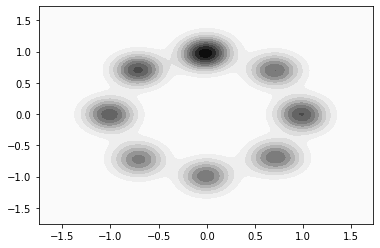

In [435]:
sns.kdeplot(dctrgan2dcirc[:,0],dctrgan2dcirc[:,1], shade=True,cmap="Greys")

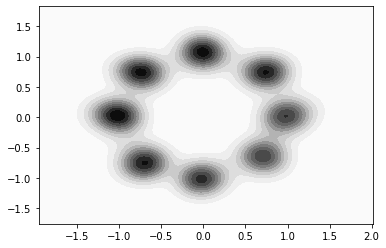

In [440]:
sns.kdeplot(X_2Dcirc_train[0:2000][:,0],X_2Dcirc_train[0:2000][:,1], shade=True,cmap="Greys")

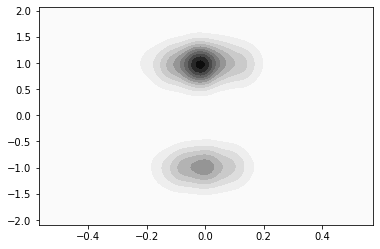

In [436]:
sns.kdeplot(dctrgan2dcirc[abs(dctrgan2dcirc[:,0]) < 0.5][:,0],dctrgan2dcirc[abs(dctrgan2dcirc[:,0]) < 0.5][:,1], shade=True,cmap="Greys")

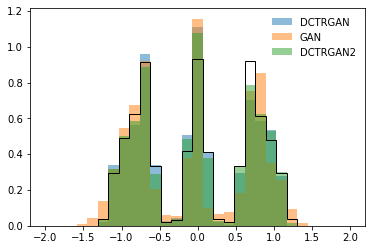

In [426]:
plt.hist(dctrgan2dcirc[:,0][0:4000],bins=np.linspace(-2,2,30),density=True,alpha=0.5,label="DCTRGAN")
plt.hist(X_2Dcirc_test[Y_2Dcirc_test[:,0]==1][:,0],bins=np.linspace(-2,2,30),density=True,alpha=0.5,label="GAN")
plt.hist(X_2Dcirc_test[Y_2Dcirc_test[:,0]==1][:,0],weights=weights_2dcirc[Y_2Dcirc_test[:,0]==1],bins=np.linspace(-2,2,30),density=True,alpha=0.5,label="DCTRGAN2")
plt.hist(X_2Dcirc_test[Y_2Dcirc_test[:,0]==0][:,0],bins=np.linspace(-2,2,30),density=True,histtype="step",color="black")
plt.legend(frameon=False)

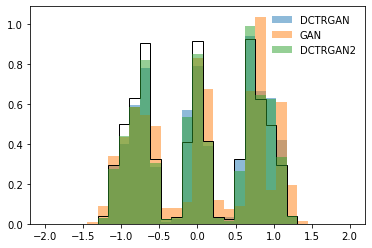

In [427]:
plt.hist(dctrgan2dcirc[:,1][0:4000],bins=np.linspace(-2,2,30),density=True,alpha=0.5,label="DCTRGAN")
plt.hist(X_2Dcirc_test[Y_2Dcirc_test[:,0]==1][:,1],bins=np.linspace(-2,2,30),density=True,alpha=0.5,label="GAN")
plt.hist(X_2Dcirc_test[Y_2Dcirc_test[:,0]==0][:,1],bins=np.linspace(-2,2,30),density=True,histtype="step",color="black")
plt.hist(X_2Dcirc_test[Y_2Dcirc_test[:,0]==1][:,1],weights=weights_2dcirc[Y_2Dcirc_test[:,0]==1],bins=np.linspace(-2,2,30),density=True,alpha=0.5,label="DCTRGAN2")
plt.legend(frameon=False)

on 2d circular plots
on GAN part
on 2d grid plots


Text(0.5, 1.0, 'DCTRGAN')

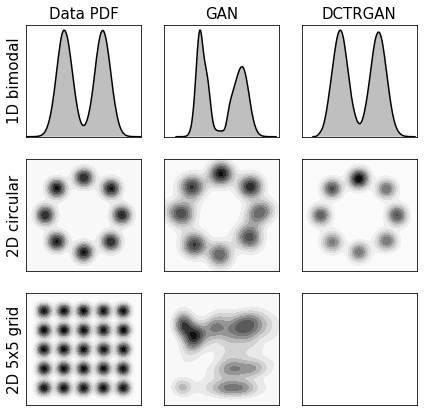

In [441]:
f, axes = plt.subplots(3, 3, figsize=(7, 7))

for i in range(3):
    for j in range(3):
        plt.sca(axes[i, j])
        plt.xticks(fontsize=0)
        plt.yticks(fontsize=0)
        plt.xticks([], [])
        plt.yticks([], [])

plt.sca(axes[0, 0])        
plt.ylabel("1D bimodal",fontsize=15)   

plt.sca(axes[1, 0])        
plt.ylabel("2D circular",fontsize=15)   

plt.sca(axes[2, 0])        
plt.ylabel("2D 5x5 grid",fontsize=15)   
    
sns.distplot(X_1D_test[Y_1D_test[:,0]==0], hist=False, color="gray", kde_kws={"shade": True,"color":"black"}, ax=axes[0, 0])
sns.distplot(X_1D_test[Y_1D_test[:,0]==1], hist=False, color="gray", kde_kws={"shade": True,"color":"black"}, ax=axes[0, 1])
sns.distplot(dctrgan1d, hist=False, color="gray", kde_kws={"shade": True,"color":"black"}, ax=axes[0, 2])

plt.sca(axes[0, 0])
plt.xlim([-3,3])

plt.sca(axes[0, 1])
plt.xlim([-3,3])

plt.sca(axes[0, 2])
plt.xlim([-3,3])

xvals = []
yvals = []
for i in range(8):
    xvals = np.concatenate([xvals,np.random.normal(np.cos(2*i*3.14/8),0.1,500)])
    yvals = np.concatenate([yvals,np.random.normal(np.sin(2*i*3.14/8),0.1,500)])
    pass

print("on 2d circular plots")
sns.kdeplot(xvals, yvals, shade=True,cmap="Greys", ax=axes[1, 0])
plt.sca(axes[1, 0])
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
print("on GAN part")
sns.kdeplot(X_2Dcirc_test[Y_2Dcirc_test[:,0]==1][:,0][0:1000],X_2Dcirc_test[Y_2Dcirc_test[:,0]==1][:,1][0:1000], shade=True,cmap="Greys", ax=axes[1, 1])
plt.sca(axes[1, 1])
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
sns.kdeplot(dctrgan2dcirc[:,0],dctrgan2dcirc[:,1], shade=True,cmap="Greys", ax=axes[1, 2])
plt.sca(axes[1, 2])
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])

xvals2 = []
yvals2 = []
for i in range(5):
    for j in range(5):
        xvals2 = np.concatenate([xvals2,np.random.normal(i+0.1,0.1,500)])
        yvals2 = np.concatenate([yvals2,np.random.normal(j+0.1,0.1,500)])
        pass
    pass

print("on 2d grid plots")
sns.kdeplot(xvals2, yvals2, shade=True,cmap="Greys", ax=axes[2, 0])    
plt.sca(axes[2, 0])
plt.xlim([-0.8,5])
plt.ylim([-0.8,5])      
    
sns.kdeplot(X_2Dsquare_test[Y_2Dsquare_test[:,0]==1][:,0][0:2000],X_2Dsquare_test[Y_2Dsquare_test[:,0]==1][:,1][0:2000], shade=True,cmap="Greys", ax=axes[2, 1])
plt.sca(axes[2, 1])
plt.xlim([-0.8,5])
plt.ylim([-0.8,5])    
    
axes[0][0].set_title('Data PDF',fontsize=15)
axes[0][1].set_title('GAN',fontsize=15)
axes[0][2].set_title('DCTRGAN',fontsize=15)

In [447]:
inputs_2dsquare = Input((2,))
hidden_layer_1_2dsquare = Dense(64, activation='relu')(inputs_2dsquare)
hidden_layer_2_2dsquare = Dense(128, activation='relu')(hidden_layer_1_2dsquare)
hidden_layer_3_2dsquare = Dense(256, activation='relu')(hidden_layer_2_2dsquare)

outputs_2dsquare = Dense(2, activation='softmax')(hidden_layer_3_2dsquare)

model_2dsquare = Model(inputs = inputs_2dsquare, outputs = outputs_2dsquare)
model_2dsquare.compile(loss='categorical_crossentropy', optimizer='Adam', )
model_2dsquare.summary()

model_2dsquare.fit(X_2Dsquare_train, Y_2Dsquare_train, 
          epochs=100, 
          batch_size = 200,
          validation_data = (X_2Dsquare_test, Y_2Dsquare_test),
          callbacks = [earlystopping])

preds_2dsquare = model_2dsquare.predict(X_2Dsquare_test)
weights_2dsquare = preds_2dsquare[:,1]/preds_2dsquare[:,0]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_269 (Dense)            (None, 64)                192       
_________________________________________________________________
dense_270 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_271 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_272 (Dense)            (None, 2)                 514       
Total params: 42,050
Trainable params: 42,050
Non-trainable params: 0
_________________________________________________________________
Train on 1600000 samples, validate on 400000 samples
Epoch 1/100
1600000/1600000 [==============================] - 57s 35us/step - loss: 

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


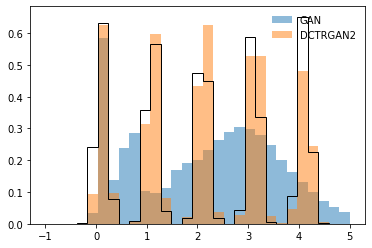

In [459]:
#plt.hist(dctrgan2dsquare[:,0][0:4000],bins=np.linspace(-2,2,30),density=True,alpha=0.5,label="DCTRGAN")
plt.hist(X_2Dsquare_test[Y_2Dsquare_test[:,0]==1][:,0],bins=np.linspace(-1,5,30),density=True,alpha=0.5,label="GAN")
plt.hist(X_2Dsquare_test[(Y_2Dsquare_test[:,0]==1) & (weights_2dsquare < 100)][:,0],weights=weights_2dsquare[(Y_2Dsquare_test[:,0]==1) & (weights_2dsquare < 100)],bins=np.linspace(-1,5,30),density=True,alpha=0.5,label="DCTRGAN2")
plt.hist(X_2Dsquare_test[Y_2Dsquare_test[:,0]==0][:,0],bins=np.linspace(-1,5,30),density=True,histtype="step",color="black")
plt.legend(frameon=False)

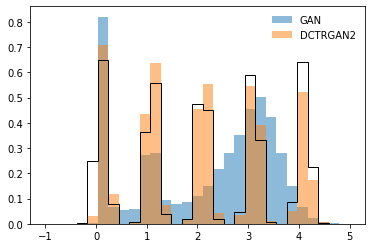

In [456]:
#plt.hist(dctrgan2dsquare[:,1][0:4000],bins=np.linspace(-2,2,30),density=True,alpha=0.5,label="DCTRGAN")
plt.hist(X_2Dsquare_test[Y_2Dsquare_test[:,0]==1][:,1],bins=np.linspace(-1,5,30),density=True,alpha=0.5,label="GAN")
plt.hist(X_2Dsquare_test[(Y_2Dsquare_test[:,0]==1) & (weights_2dsquare < 100)][:,1],weights=weights_2dsquare[(Y_2Dsquare_test[:,0]==1) & (weights_2dsquare < 100)],bins=np.linspace(-1,5,30),density=True,alpha=0.5,label="DCTRGAN2")
plt.hist(X_2Dsquare_test[Y_2Dsquare_test[:,0]==0][:,1],bins=np.linspace(-1,5,30),density=True,histtype="step",color="black")
plt.legend(frameon=False)

In [492]:
dctrgan2dsquare = np.array(resample(X_2Dsquare_test[(Y_2Dsquare_test[:,0]==1) & (weights_2dsquare < 100)],weights_2dsquare[(Y_2Dsquare_test[:,0]==1) & (weights_2dsquare < 100)],4000))

0
0.0
0.00059148425


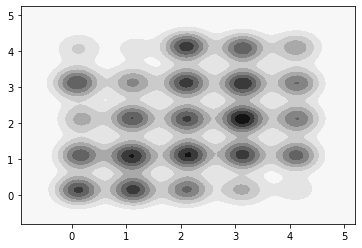

In [493]:
sns.kdeplot(dctrgan2dsquare[:,0],dctrgan2dsquare[:,1], shade=True,cmap="Greys")

on 2d circular plots
on GAN part
on 2d grid plots


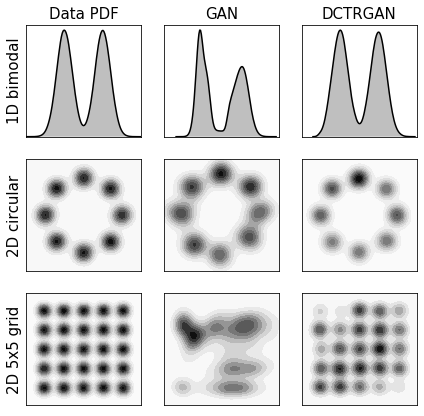

In [494]:
f, axes = plt.subplots(3, 3, figsize=(7, 7))

for i in range(3):
    for j in range(3):
        plt.sca(axes[i, j])
        plt.xticks(fontsize=0)
        plt.yticks(fontsize=0)
        plt.xticks([], [])
        plt.yticks([], [])

plt.sca(axes[0, 0])        
plt.ylabel("1D bimodal",fontsize=15)   

plt.sca(axes[1, 0])        
plt.ylabel("2D circular",fontsize=15)   

plt.sca(axes[2, 0])        
plt.ylabel("2D 5x5 grid",fontsize=15)   
    
sns.distplot(X_1D_test[Y_1D_test[:,0]==0], hist=False, color="gray", kde_kws={"shade": True,"color":"black"}, ax=axes[0, 0])
sns.distplot(X_1D_test[Y_1D_test[:,0]==1], hist=False, color="gray", kde_kws={"shade": True,"color":"black"}, ax=axes[0, 1])
sns.distplot(dctrgan1d, hist=False, color="gray", kde_kws={"shade": True,"color":"black"}, ax=axes[0, 2])

plt.sca(axes[0, 0])
plt.xlim([-3,3])

plt.sca(axes[0, 1])
plt.xlim([-3,3])

plt.sca(axes[0, 2])
plt.xlim([-3,3])

xvals = []
yvals = []
for i in range(8):
    xvals = np.concatenate([xvals,np.random.normal(np.cos(2*i*3.14/8),0.1,500)])
    yvals = np.concatenate([yvals,np.random.normal(np.sin(2*i*3.14/8),0.1,500)])
    pass

print("on 2d circular plots")
sns.kdeplot(xvals, yvals, shade=True,cmap="Greys", ax=axes[1, 0])
plt.sca(axes[1, 0])
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
print("on GAN part")
sns.kdeplot(X_2Dcirc_test[Y_2Dcirc_test[:,0]==1][:,0][0:1000],X_2Dcirc_test[Y_2Dcirc_test[:,0]==1][:,1][0:1000], shade=True,cmap="Greys", ax=axes[1, 1])
plt.sca(axes[1, 1])
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
sns.kdeplot(dctrgan2dcirc[:,0],dctrgan2dcirc[:,1], shade=True,cmap="Greys", ax=axes[1, 2])
plt.sca(axes[1, 2])
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])

xvals2 = []
yvals2 = []
for i in range(5):
    for j in range(5):
        xvals2 = np.concatenate([xvals2,np.random.normal(i+0.1,0.1,500)])
        yvals2 = np.concatenate([yvals2,np.random.normal(j+0.1,0.1,500)])
        pass
    pass

print("on 2d grid plots")
sns.kdeplot(xvals2, yvals2, shade=True,cmap="Greys", ax=axes[2, 0])    
plt.sca(axes[2, 0])
plt.xlim([-0.8,5])
plt.ylim([-0.8,5])      
    
sns.kdeplot(X_2Dsquare_test[Y_2Dsquare_test[:,0]==1][:,0][0:2000],X_2Dsquare_test[Y_2Dsquare_test[:,0]==1][:,1][0:2000], shade=True,cmap="Greys", ax=axes[2, 1])
plt.sca(axes[2, 1])
plt.xlim([-0.8,5])
plt.ylim([-0.8,5])    

sns.kdeplot(dctrgan2dsquare[:,0],dctrgan2dsquare[:,1], shade=True,cmap="Greys", ax=axes[2, 2])
plt.sca(axes[2, 2])
plt.xlim([-0.8,5])
plt.ylim([-0.8,5])    

axes[0][0].set_title('Data PDF',fontsize=15)
axes[0][1].set_title('GAN',fontsize=15)
axes[0][2].set_title('DCTRGAN',fontsize=15)

plt.savefig("SimpleExampleComparison.pdf")